# Fan Video

In this notebook we will estimate the Optical Flow of the rotating ceiling fan and create a GIF of it

In [1]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append('RAFT/core')
     
from raft_utils import *

#### Get Data

In [3]:
from glob import glob

frame_paths = sorted(glob(os.path.join('test_images', f'*.png')))
frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#### Get Model

In [4]:
# load model
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

In [44]:
# store results
cold_flow_frames = []
flow_frames = []

# warm start
prev_frame = cv2.cvtColor(cv2.imread(frame_paths[0]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(cv2.imread(frame_paths[1]), cv2.COLOR_BGR2RGB)
flow_lo, flow_up = inference(model, prev_frame, frame, device='cuda', iters=25, pad_mode=None, test_mode=True)

flow_frames.append(flow_up)
cold_flow_frames.append(flow_up)
prev_frame = frame.copy()

for i, fp in enumerate(frame_paths[2:]):
    frame = cv2.cvtColor(cv2.imread(fp), cv2.COLOR_BGR2RGB)

    cold_flow_lo, cold_flow_up = inference(model, prev_frame, frame, device='cuda', flow_init=None, iters=25, pad_mode=None, test_mode=True)
    flow_lo, flow_up = inference(model, prev_frame, frame, device='cuda', flow_init=flow_lo, iters=25, pad_mode=None, test_mode=True)

    flow_frames.append(flow_up)
    cold_flow_frames.append(cold_flow_up)
    prev_frame = frame.copy()




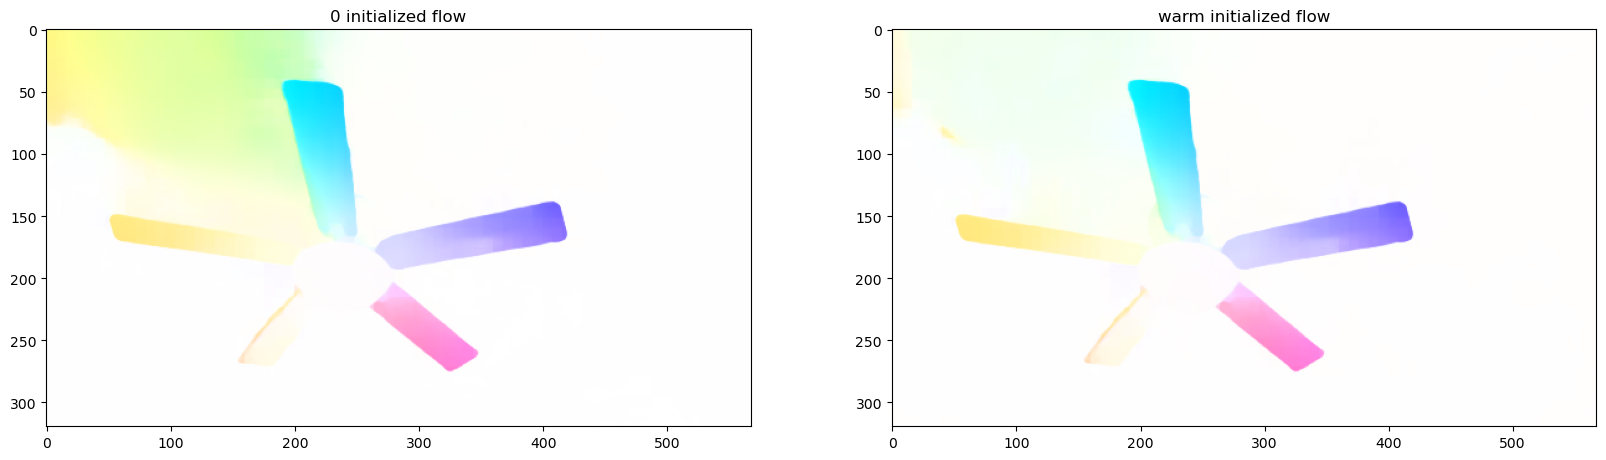

In [57]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(cold_flow_frames[50]))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(flow_frames[50]))
ax1.set_title('warm initialized flow');

In [47]:
cold_flow_frames[0] - flow_frames[0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [ ]:
plt.imshow(get_viz(flow_frames[1]))

Sanity Check

In [61]:
frame1 = cv2.cvtColor(cv2.imread(frame_paths[1]), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread(frame_paths[2]), cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(cv2.imread(frame_paths[3]), cv2.COLOR_BGR2RGB)

In [39]:
# get previous estimate at 1/8 res
flow_lo, flow_up = inference(model, frame1, frame2, device='cuda', pad_mode=None, iters=20, test_mode=True)

# 0 initialization
flow_lo_cold, flow_up_cold = inference(model, frame2, frame3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

# warm initialization
flow_lo_warm, flow_up_warm = inference(model, frame2, frame3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)


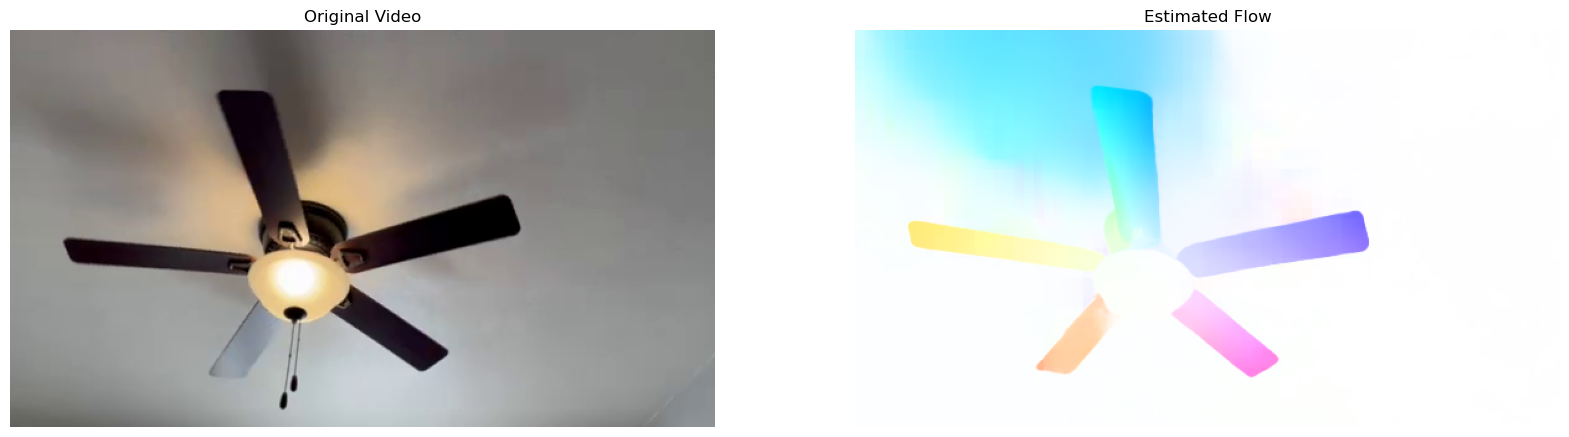

In [68]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame3)
ax0.set_title('Original Video')
ax0.axis(False)
ax1.imshow(get_viz(flow_up_warm))
ax1.axis(False)
ax1.set_title('Estimated Flow');

## Make the GIF

In [64]:
from PIL import Image


def create_gif_from_images(save_path, image_path, ext):
    ''' creates a GIF from a folder of images
        Inputs:
            save_path (str) - path to save GIF
            image_path (str) - path where images are located
            ext (str) - extension of the images
        Outputs:
            None
        
        Update:
            Add functionality for multiple extensions
    '''
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))

    pil_images = [Image.open(im_path ) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)
    

In [77]:
for i, (fp, flo) in enumerate(zip(frame_paths[1:], flow_frames)):
    frame = cv2.cvtColor(cv2.imread(fp), cv2.COLOR_BGR2RGB)

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

    ax0.imshow(frame)
    ax0.set_title('Original Video')
    ax0.axis(False)
    ax1.imshow(get_viz(flo))
    ax1.axis(False)
    ax1.set_title('Estimated Flow');

    fig.savefig(f"test_images/flow_{i}.jpg")
    plt.close();
    

In [78]:

gif_frame_paths = sorted(glob(os.path.join('test_images', f'*.jpg')))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'test_images/flow.gif'


In [82]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)